In [1]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Misc.
import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Drug_Test_Excel.xlsx to Drug_Test_Excel.xlsx
Saving Drug_Train_Excel.xlsx to Drug_Train_Excel.xlsx


In [3]:
# Importing excel files of Training and Test Dataset. 
import io
train = pd.read_excel(io.BytesIO(uploaded['Drug_Train_Excel.xlsx']))
test = pd.read_excel(io.BytesIO(uploaded['Drug_Test_Excel.xlsx']))

In [4]:
#Finding the shape of Training Dataset.
print("Shape of training dataset:", train.shape)
train.head()

Shape of training dataset: (161297, 7)


,Column1,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


In [5]:
#Finding the shape of Testing Dataset.
print("Shape of testing dataset:", test.shape)
test.head()

Shape of testing dataset: (53766, 7)


,Column1,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,2012-02-28,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,2009-05-17,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,2017-09-29,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,2017-03-05,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,2015-10-22,4


In [6]:
# From the above two ouputs we can see that both the dataset contains same columns, we can combine them for better analysis.

data = pd.concat([train, test])
print("Shape of dataset after combining both train & test:", data.shape)
data.head()

Shape of dataset after combining both train & test: (215063, 7)


,Column1,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


In [7]:
#Features of dataset with values.
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Column1,215063.0,116039.364814,67007.913366,0.0,58115.5,115867.0,173963.5,232291.0
rating,215063.0,6.990008,3.275554,1.0,5.0,8.0,10.0,10.0
usefulCount,215063.0,28.001004,36.346069,0.0,6.0,16.0,36.0,1291.0


In [8]:
#Combined Data information.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Column1      215063 non-null  int64         
 1   drugName     215063 non-null  object        
 2   condition    213869 non-null  object        
 3   review       215063 non-null  object        
 4   rating       215063 non-null  int64         
 5   date         215063 non-null  datetime64[ns]
 6   usefulCount  215063 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 13.1+ MB


In [9]:
#changing column name.
data = data.rename(columns={'Column1': 'uniqueid'})

In [10]:
#Checking for data types of features.
data.dtypes

uniqueid                int64
drugName               object
condition              object
review                 object
rating                  int64
date           datetime64[ns]
usefulCount             int64
dtype: object

In [11]:
#Checking for Null values.
data.isnull().any()

uniqueid       False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

In [12]:
#Checking for sum of null values in each feature.
data.isnull().sum()

uniqueid          0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

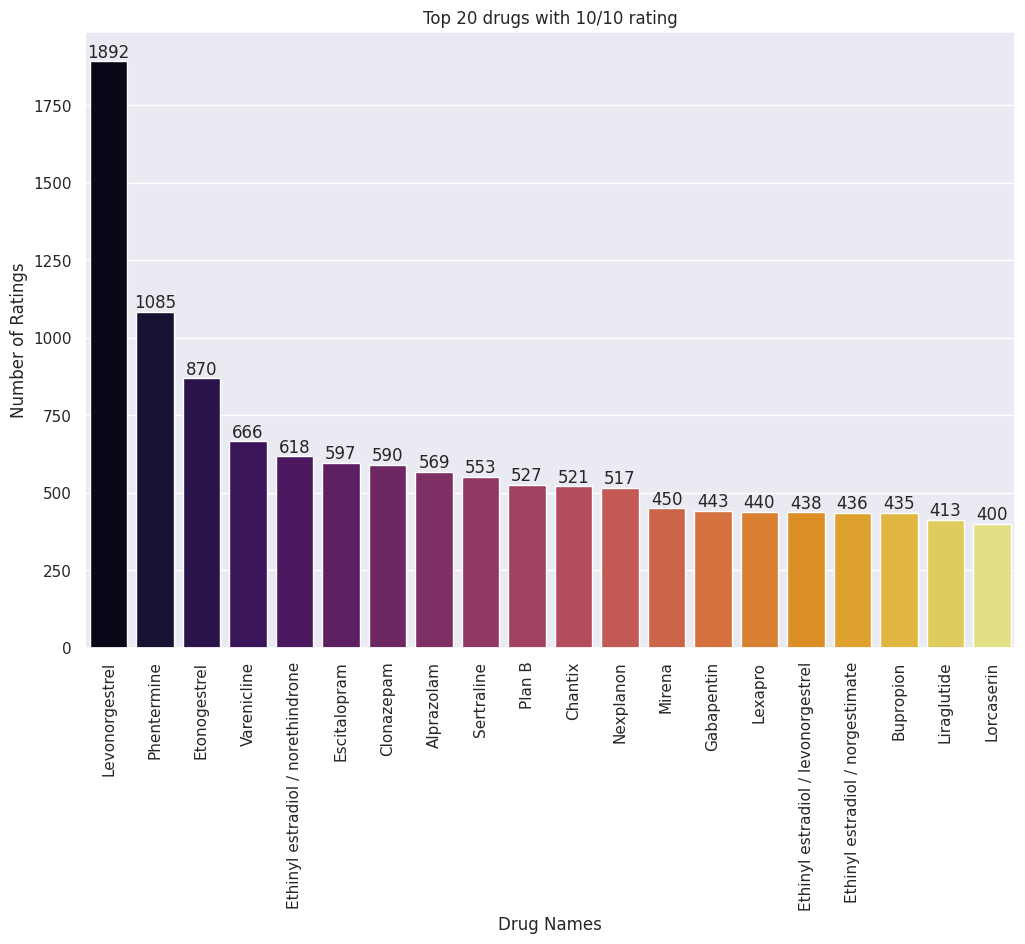

In [13]:
sns.set(font_scale = 1, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [12, 8] #Size of Plot

rating = dict(data.loc[data.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

#sns.plot(sns.color_palette("Greys"))
sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette='inferno')


for i in sns_rating.containers:
    sns_rating.bar_label(i,)

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90)
plt.show()

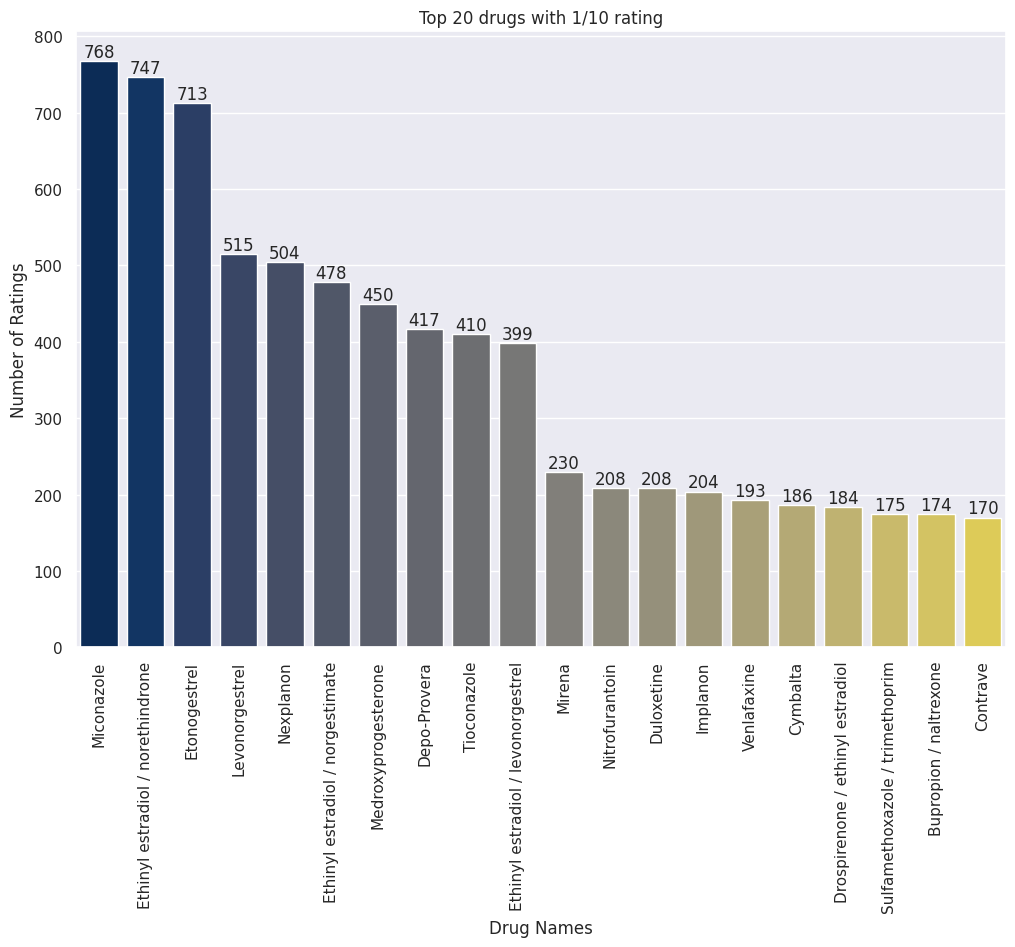

In [14]:
sns.set(font_scale = 1, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [12, 8]

rating = dict(data.loc[data.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'cividis')

for i in sns_rating.containers:
    sns_rating.bar_label(i,)

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90) #Rotation (90 degree) is necessary to remove overlapping of text on x-axis. 
plt.show()

In [15]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

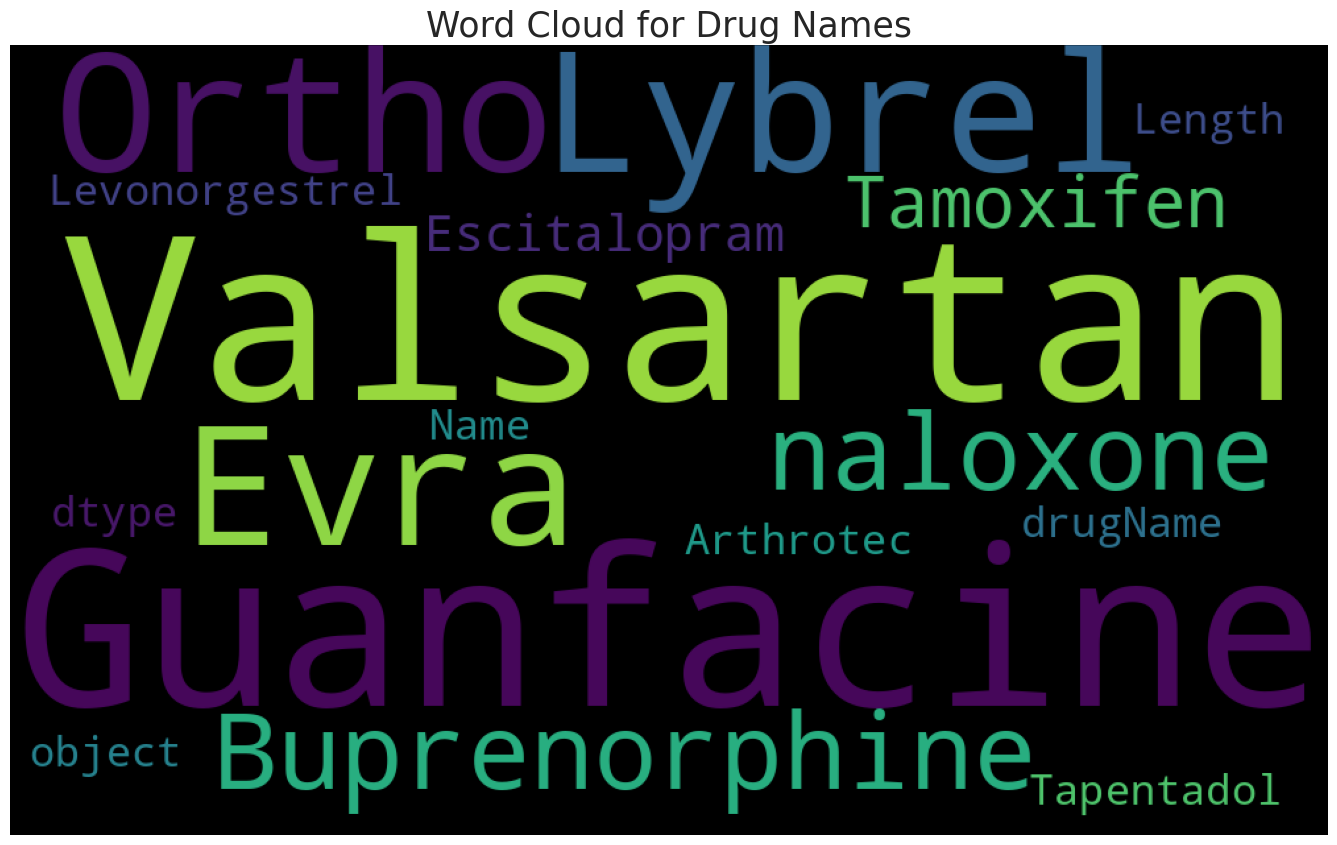

In [16]:
#Highlighting most popular Drugs.

stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords = stopwords, width = 1000, height = 600).generate(str(data['drugName']))

plt.rcParams['figure.figsize'] = (17, 17)
plt.title('Word Cloud for Drug Names', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

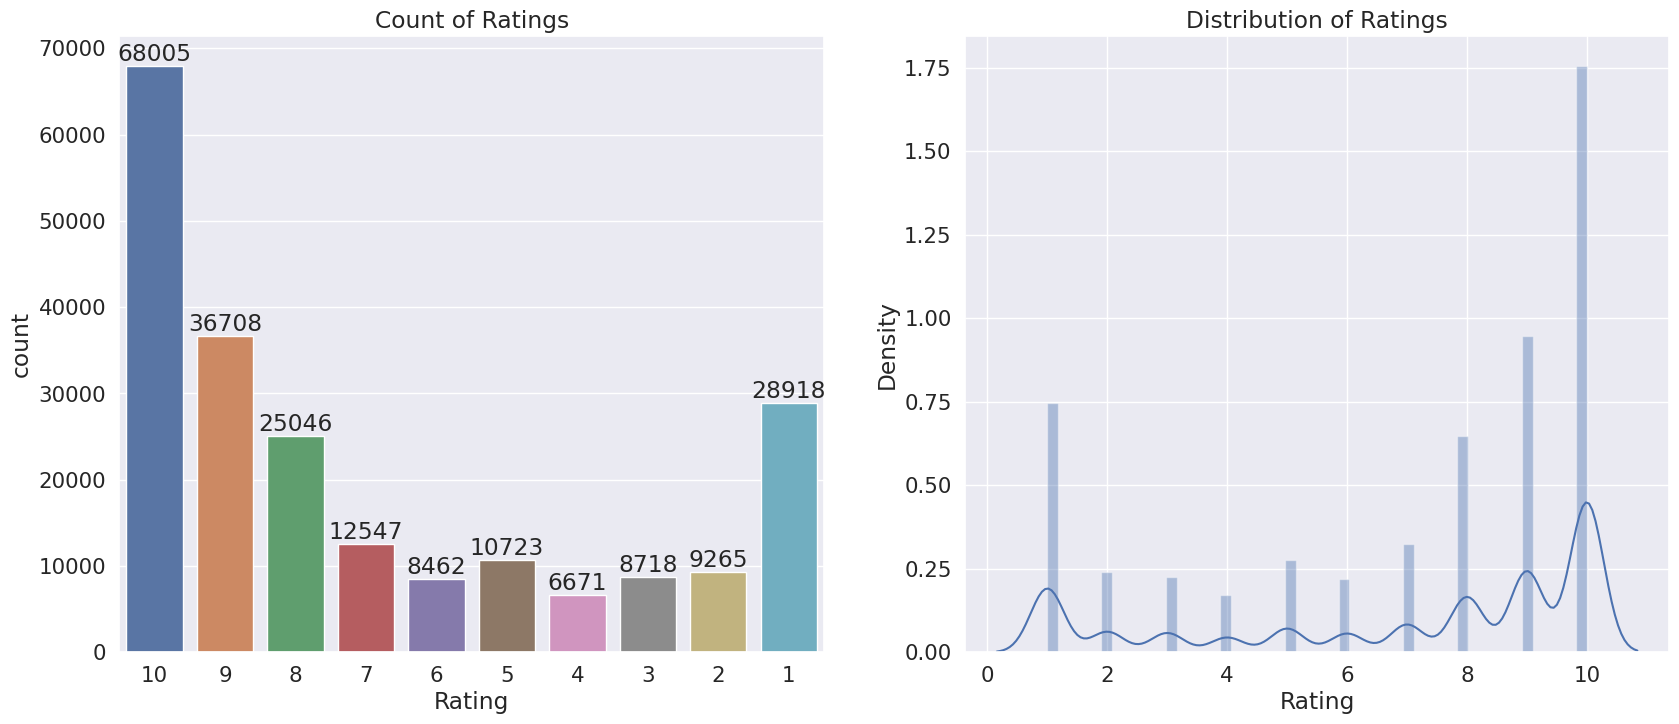

In [17]:
plt.rcParams['figure.figsize'] = [20,8]
sns.set(font_scale = 1.4, style = 'darkgrid')
fig, ax = plt.subplots(1, 2)

sns_1 = sns.countplot(x='rating', data=data, palette = 'deep', order = list(range(10, 0, -1)), ax = ax[0])

for i in sns_1.containers: #This loop adds labels to the bars of the countplot.
    sns_1.bar_label(i,)
    
sns_2 = sns.distplot(data['rating'], ax = ax[1])
sns_1.set_title('Count of Ratings')
sns_1.set_xlabel("Rating")

sns_2.set_title('Distribution of Ratings')
sns_2.set_xlabel("Rating")
plt.show()

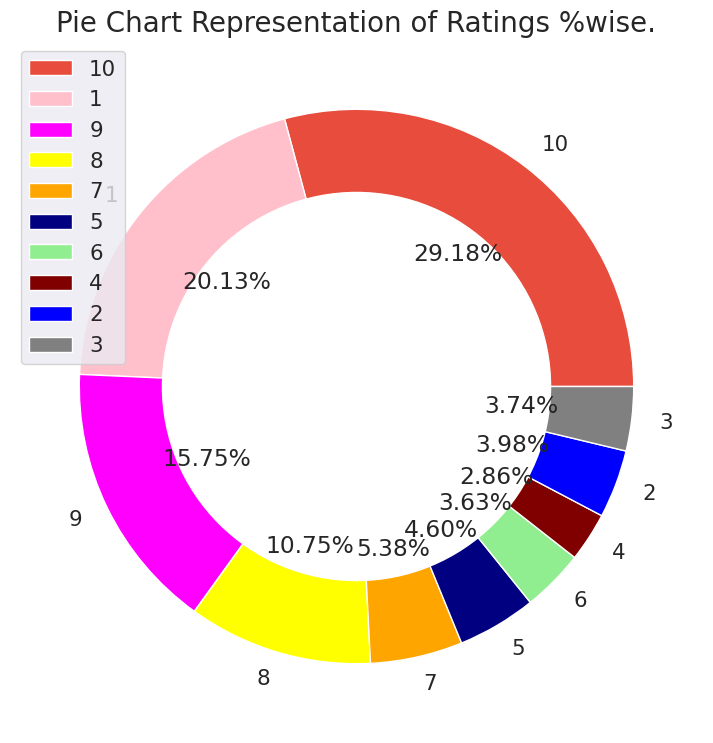

In [18]:
size = [68005, 46901, 36708, 25046, 12547, 10723, 8462, 6671, 9265, 8718]
colors = ['#e74c3c', 'pink', 'magenta',  'yellow', 'orange', 'navy', 'lightgreen', 'maroon','blue','grey']
labels = "10", "1", "9", "8", "7", "5", "6", "4", "2", "3"

my_circle = plt.Circle((0, 0), 0.7, color = 'white') #Defining the parameters for pie chart.

plt.rcParams['figure.figsize'] = (9, 9) #Defining fig. size
plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%') #pie chart in percent wise.
plt.axis('off')
plt.title('Pie Chart Representation of Ratings %wise.', fontsize = 20)
p = plt.gcf()
plt.gca().add_artist(my_circle) #adds the white circle to the pie chart.
plt.legend()
plt.show()

Text(0, 0.5, 'Count')

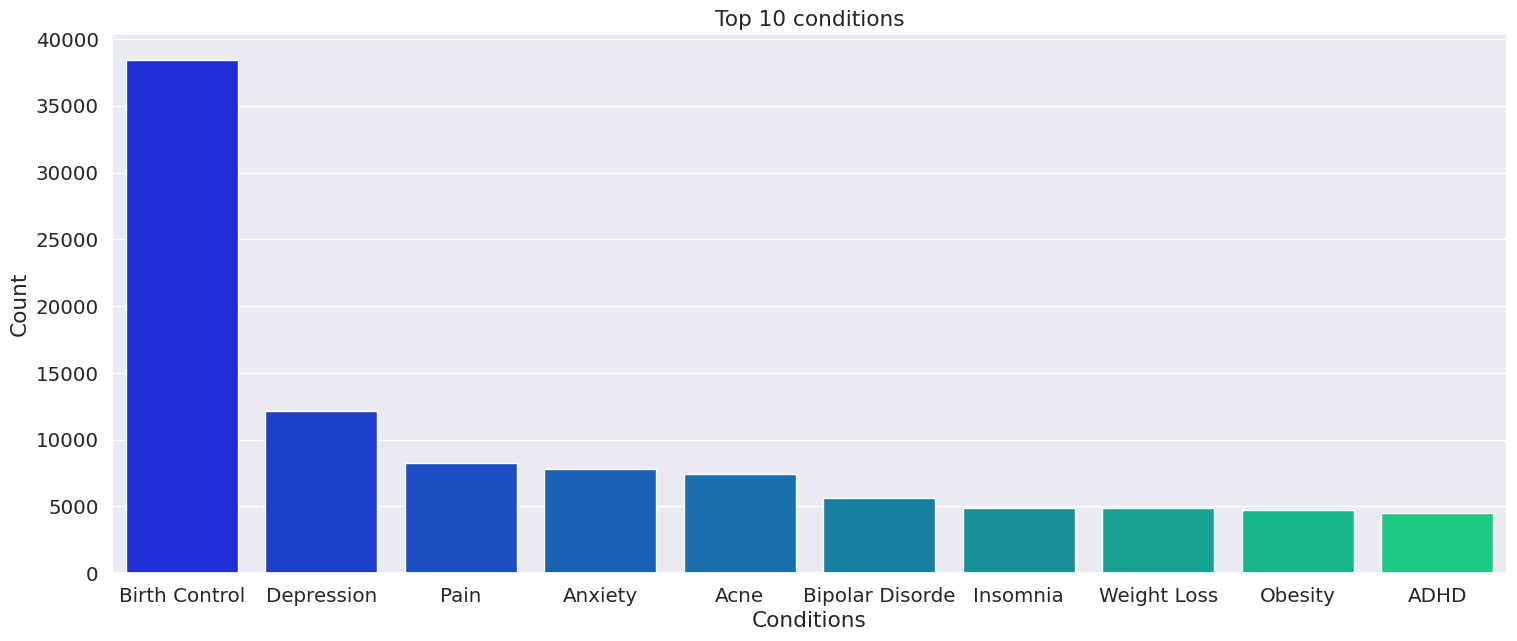

In [19]:
cond = dict(data['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [18, 7]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count")

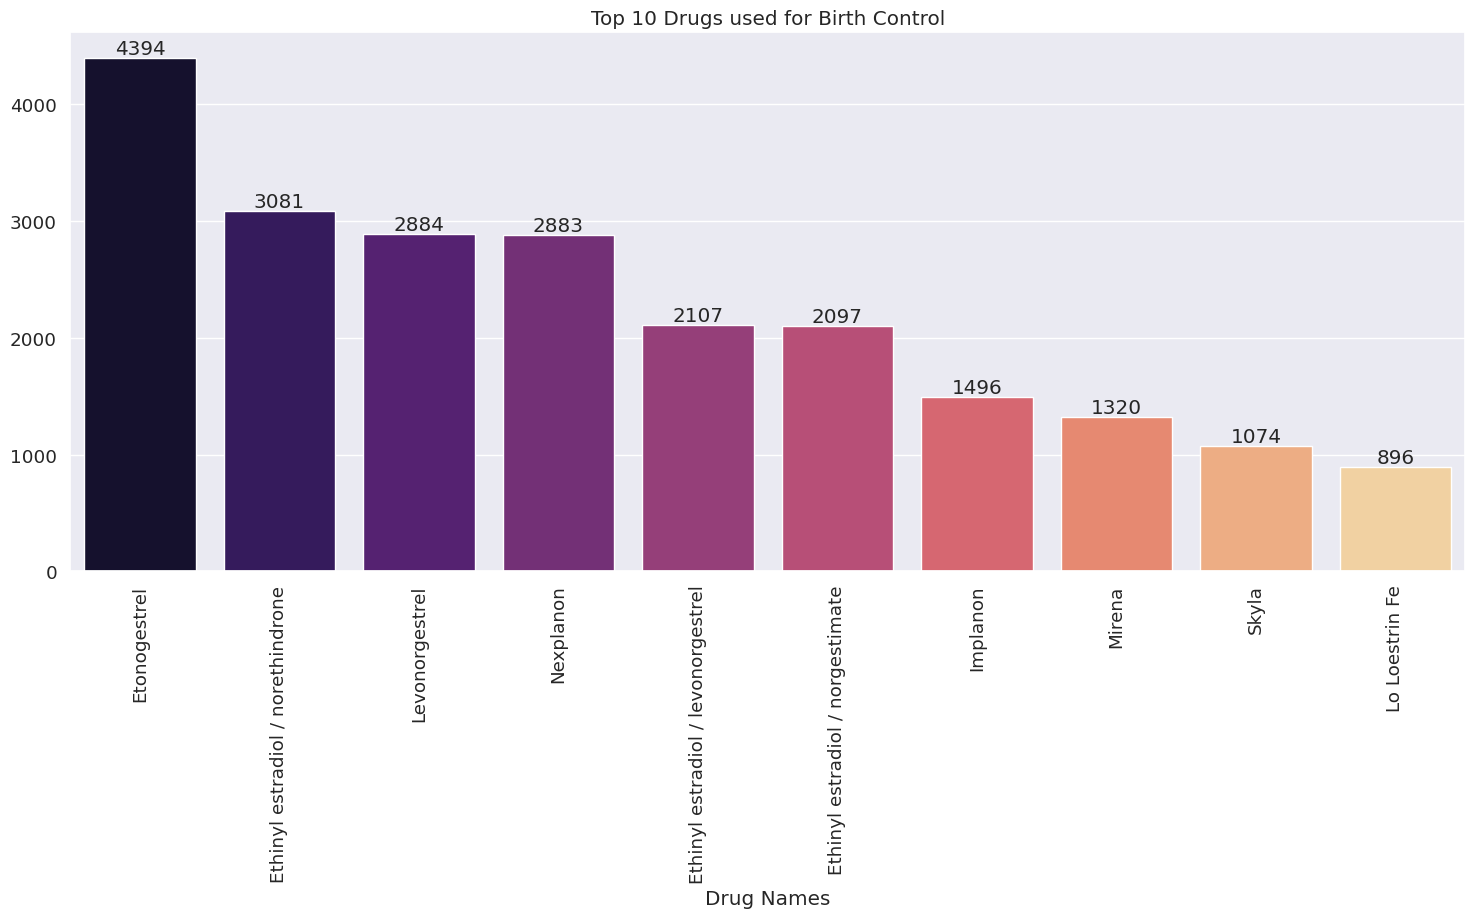

In [20]:
df1 = data[data['condition'] == 'Birth Control']['drugName'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = df1.index, y = df1.values, palette = 'magma')

for i in sns_.containers:
    sns_.bar_label(i,)
    
sns_.set_xlabel('Drug Names')
sns_.set_title("Top 10 Drugs used for Birth Control")
plt.setp(sns_.get_xticklabels(), rotation = 90)
plt.show()

In [21]:
# feature engineering 
# let's make a new column named "review sentiment"

data.loc[(data['rating'] >= 5), 'Review_Sentiment'] = 1
data.loc[(data['rating'] < 5), 'Review_Sentiment'] = 0

data['Review_Sentiment'].value_counts()

1.0    161491
0.0     53572
Name: Review_Sentiment, dtype: int64

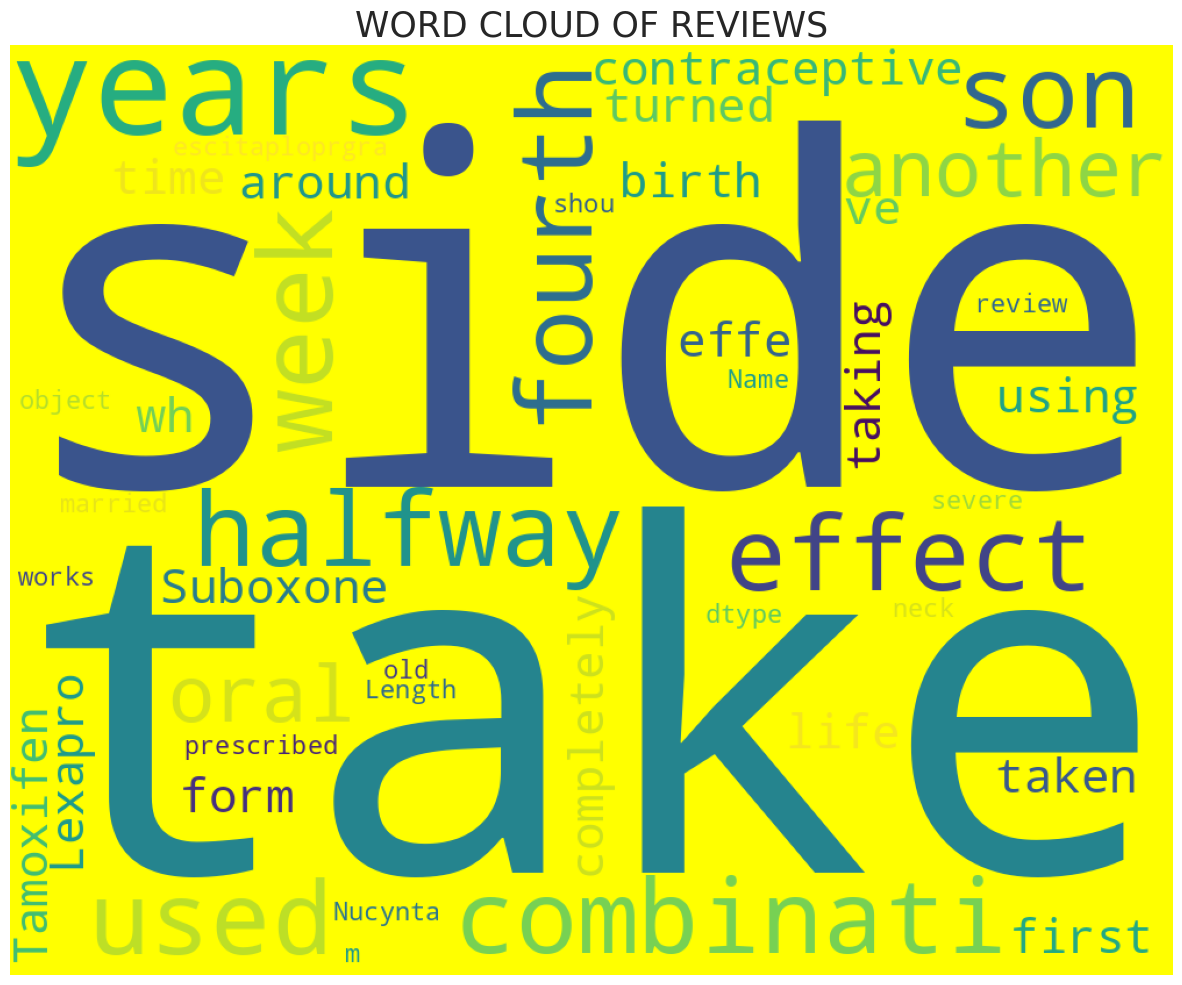

In [22]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color = 'yellow', stopwords = stopwords, width = 1000, height = 800).generate(str(data['review']))

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('WORD CLOUD OF REVIEWS', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

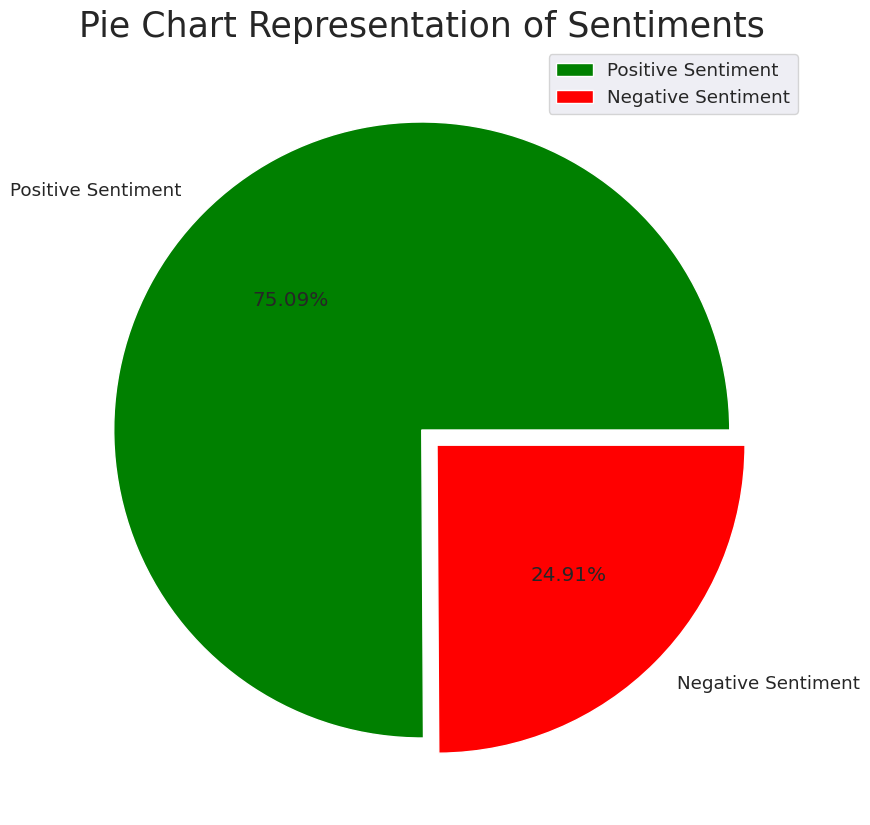

In [23]:
# Creating Pie charts with percentatage of Negative and Positive Sentiments.
size = [161491, 53572]
colors = ['Green', 'red']
labels = "Positive Sentiment","Negative Sentiment"
explode = [0, 0.07]

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, explode = explode, autopct = '%.2f%%')
plt.axis('off')
plt.title('Pie Chart Representation of Sentiments', fontsize = 25)
plt.legend()
plt.show()

In [24]:
#Checking Data columns.
data.columns

Index(['uniqueid', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount', 'Review_Sentiment'],
      dtype='object')

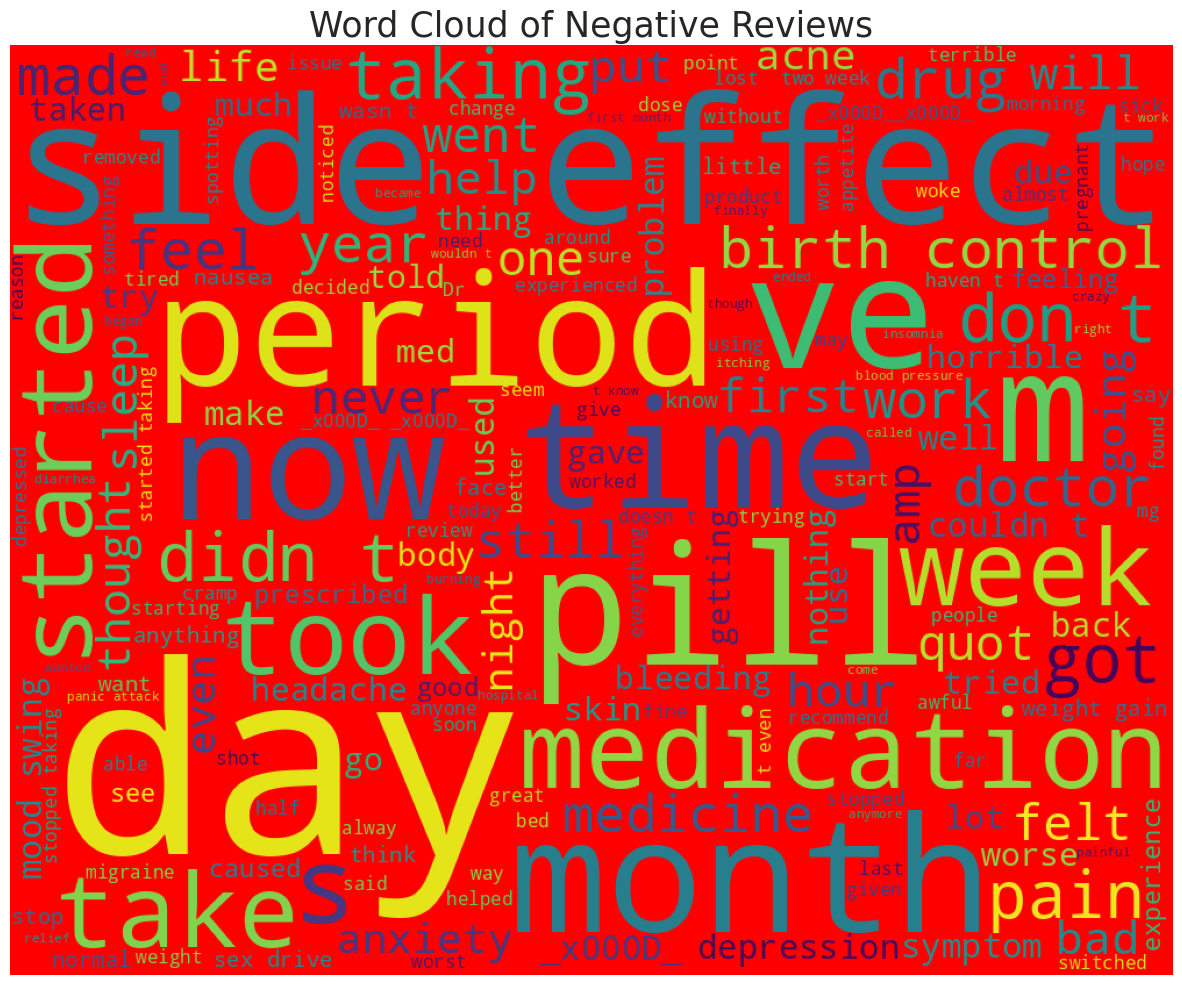

In [25]:
negative_sentiments = " ".join([text for text in data['review'][data['Review_Sentiment'] == 0]])

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'red', stopwords = stopwords, width = 1000, height = 800).generate(negative_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud of Negative Reviews', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

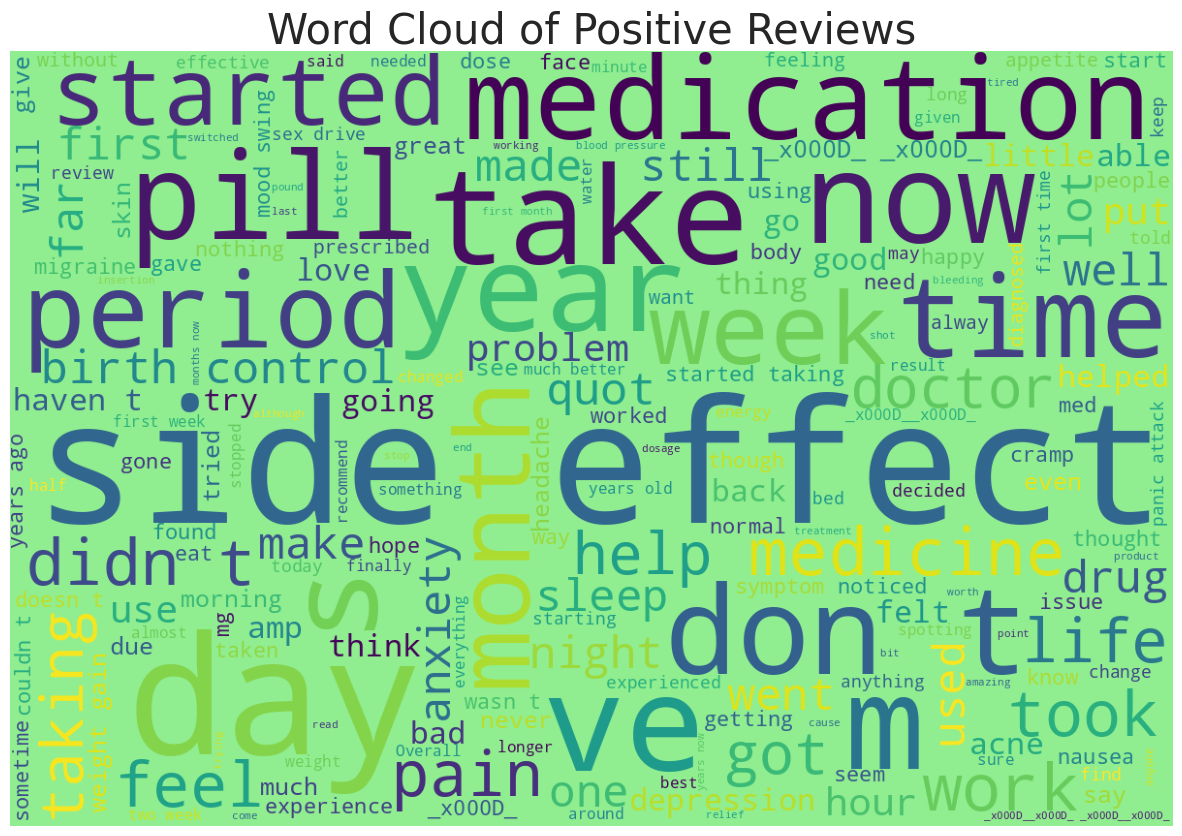

In [26]:
positive_sentiments = " ".join([text for text in data['review'][data['Review_Sentiment'] == 1]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'lightGreen', stopwords = stopwords, width = 1200, height = 800).generate(positive_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud of Positive Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [27]:
# extracting year from date
data['Year'] = data['date'].dt.year

# extracting the month from the date
data['month'] = data['date'].dt.month

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   uniqueid          215063 non-null  int64         
 1   drugName          215063 non-null  object        
 2   condition         213869 non-null  object        
 3   review            215063 non-null  object        
 4   rating            215063 non-null  int64         
 5   date              215063 non-null  datetime64[ns]
 6   usefulCount       215063 non-null  int64         
 7   Review_Sentiment  215063 non-null  float64       
 8   Year              215063 non-null  int64         
 9   month             215063 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 18.0+ MB


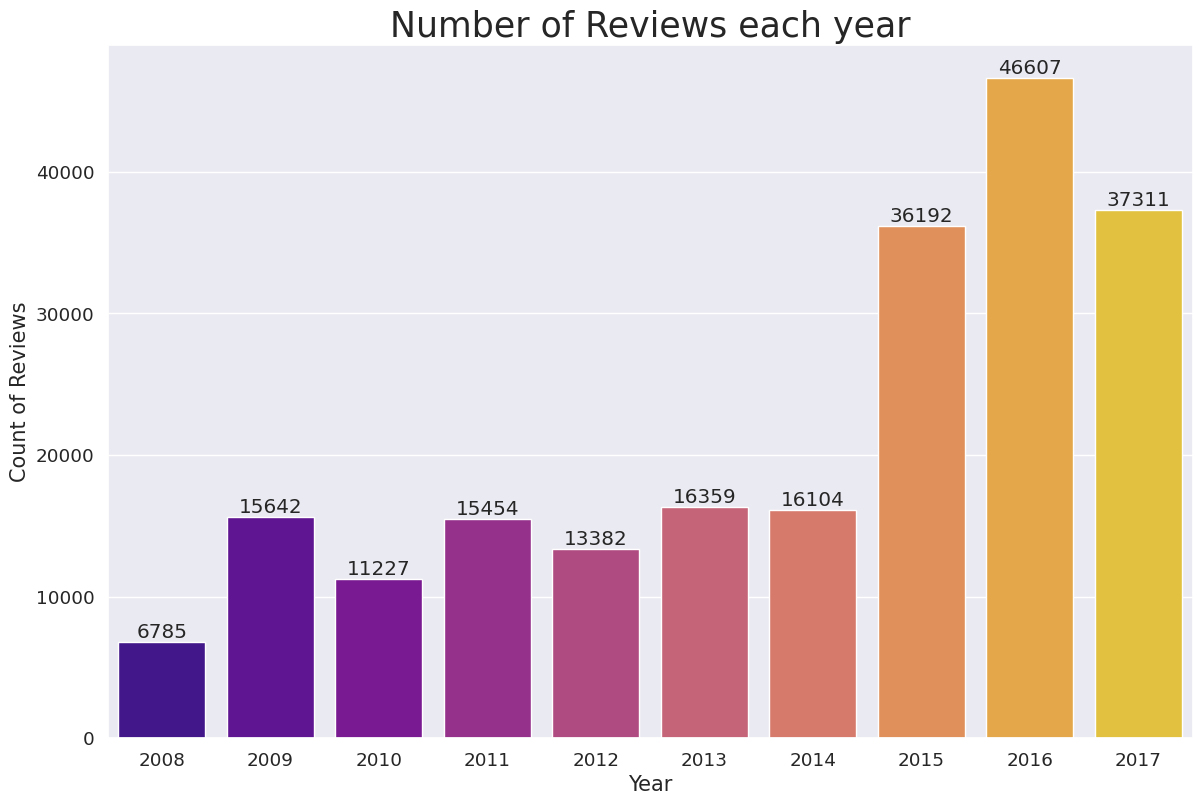

In [29]:
plt.rcParams['figure.figsize'] = (14, 9)
sns_=sns.countplot(x='Year', data=data, palette ='plasma', )

for i in sns_.containers:
    sns_.bar_label(i,)
    
plt.title('Number of Reviews each year', fontsize = 25)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Count of Reviews', fontsize = 15)
plt.show()

# Data Preprocessing and BERT Model Implementation.

In [30]:
#test = pd.read_csv('C:/Users/Sarthak/OneDrive/Desktop/DMML2/Drug_Test_Excel.xlsx')
#test.head()

In [31]:
test = test[['review','rating']]
test.head()

,review,rating
0,"""I&#039;ve tried a few antidepressants over th...",10
1,"""My son has Crohn&#039;s disease and has done ...",8
2,"""Quick reduction of symptoms""",9
3,"""Contrave combines drugs that were used for al...",9
4,"""I have been on this birth control for one cyc...",9


In [32]:
test.shape

(53766, 2)

In [33]:
!pip install bert-for-tf2
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30531 sha256=5ccb855297b6033da59fe91a0a817256ff007d2f4c3ae812fb3d9197ac916e67
  Stored in directory: /root/.cache/pip/wheels/d8/da/50/126d7b8416d9a0e6bf876935c2219a71e72a6529c25e150c56
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19471 sha256=cd1a72b03399db292b1c42f05fd1cedf644c21bdff80ea129cdc6e49dc3f9dd9
  Stored in directory: /root/.cache/pip/wheels/97/a8/d0/f7419404174976a2686bb98b5c30df01cc71445415f32db9e6
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7910 sha256=aa4dd7b991733eab6c6004be869a7ce3333fef3fc81a0b6345b90a7a78db0546
  Sto

In [34]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [35]:
def clean_review(review):
    tweet = BeautifulSoup(review, "lxml").get_text()
    # Delete the @
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', review)
    # Delete URL links
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', review)
    # Just keep letters and important punctuation
    tweet = re.sub(r"[^a-zA-Z.!?']", ' ', review)
    # Remove additional spaces
    tweet = re.sub(r" +", ' ', review)
    return review

In [36]:
data_clean = [clean_review(review) for review in test.review]

In [37]:
test.rating.unique()

array([10,  8,  9,  4,  6,  7,  2,  1,  3,  5])

In [38]:
# convert the 'rating' column to binary
test['sentiment'] = test['rating'].apply(lambda x: 1 if x > 5 else 0)

In [39]:
test.head()

,review,rating,sentiment
0,"""I&#039;ve tried a few antidepressants over th...",10,1
1,"""My son has Crohn&#039;s disease and has done ...",8,1
2,"""Quick reduction of symptoms""",9,1
3,"""Contrave combines drugs that were used for al...",9,1
4,"""I have been on this birth control for one cyc...",9,1


In [40]:
FullTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [41]:
def encode_sentence(sent):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent))

In [42]:
data_inputs = [encode_sentence(sentence) for sentence in data_clean]

In [43]:
data_labels = test.sentiment.values
data_labels[data_labels == 1] = 1

In [44]:
data_with_len = [[sent, data_labels[i], len(sent)]
                 for i, sent in enumerate(data_inputs)]
random.shuffle(data_with_len)
data_with_len.sort(key=lambda x: x[2])
sorted_all = [(sent_lab[0], sent_lab[1])
              for sent_lab in data_with_len if sent_lab[2] > 7]

In [45]:
# A list is a type of iterator so it can be used as generator for a dataset
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all,
                                             output_types=(tf.int32, tf.int32))

In [46]:
next(iter(all_dataset))

(<tf.Tensor: shape=(8,), dtype=int32, numpy=
 array([ 1000,  2079,  2025,  2202, 17710, 13944,   999,  1000],
       dtype=int32)>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>)

In [47]:
BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [48]:
next(iter(all_batched))

(<tf.Tensor: shape=(32, 8), dtype=int32, numpy=
 array([[ 1000,  2079,  2025,  2202, 17710, 13944,   999,  1000],
        [ 1000,  2224,  2009,  1998,  2293,  1996,  3463,  1000],
        [ 1000,  2573,  3435,  3132,  2217,  3896,  1012,  1000],
        [ 1000,  2009,  2038,  2499,  2005,  2033,   999,  1000],
        [ 1000,  1996,  2190,  2518,  1045,  2412,  4149,  1000],
        [ 1000,  2515,  2025,  2147,  2005,  2033,  1012,  1000],
        [ 1000,  1037,  5777, 17357,  1012,  6659,  1012,  1000],
        [ 1000,  2069,  7620,  2052,  2022,  1037,  7279,  1000],
        [ 1000, 10433, 12476,  1012,  2573, 16278,  1012,  1000],
        [ 1000,  5552,  2026,  2166,   999,   999,   999,  1000],
        [ 1000,  3449, 18891,  2140,  3271,  3202,  1012,  1000],
        [ 1000,  2038,  3087,  4227,  3635,  2006,  2023,  1000],
        [ 1000,  7263, 29476,  2075,  1997,  6812,  9050,  1000],
        [ 1000,  2200,  4621,  2005,  7143,  3255,  4335,  1000],
        [ 1000,  7126,  2026

In [49]:
NB_BATCHES = math.ceil(len(sorted_all) / BATCH_SIZE)
NB_BATCHES_TEST = NB_BATCHES // 10
all_batched.shuffle(NB_BATCHES)
test_dataset = all_batched.take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_TEST)

In [50]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x) # (batch_size, nb_filters, seq_len-1)
        x_1 = self.pool(x_1) # (batch_size, nb_filters)
        x_2 = self.trigram(x) # (batch_size, nb_filters, seq_len-2)
        x_2 = self.pool(x_2) # (batch_size, nb_filters)
        x_3 = self.fourgram(x) # (batch_size, nb_filters, seq_len-3)
        x_3 = self.pool(x_3) # (batch_size, nb_filters)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

In [51]:
VOCAB_SIZE = len(tokenizer.vocab)
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2

DROPOUT_RATE = 0.2

NB_EPOCHS = 5

In [52]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [53]:
from tensorflow.keras.metrics import Precision, Recall

In [54]:
if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy",Precision(name='precision'), Recall(name='recall')])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy",Precision(name='precision'), Recall(name='recall')])

In [55]:
history = Dcnn.fit(train_dataset, epochs=NB_EPOCHS)

# Get the loss values from the history object
loss_values = history.history['loss']

Epoch 1/5
1500/1500 [==============================] - 290s 183ms/step - loss: 0.3944 - accuracy: 0.8207 - precision: 0.8446 - recall: 0.9107
Epoch 2/5
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2574 - accuracy: 0.8966 - precision: 0.9185 - recall: 0.9348
Epoch 3/5
1500/1500 [==============================] - 19s 12ms/step - loss: 0.1341 - accuracy: 0.9524 - precision: 0.9639 - recall: 0.9681
Epoch 4/5
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0938 - accuracy: 0.9648 - precision: 0.9735 - recall: 0.9761
Epoch 5/5
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0645 - accuracy: 0.9760 - precision: 0.9823 - recall: 0.9834


In [56]:
# Print the loss values for each epoch
for i, loss in enumerate(loss_values):
    print(f"Epoch {i}: Loss = {loss}")

Epoch 0: Loss = 0.3943600654602051
Epoch 1: Loss = 0.2573528289794922
Epoch 2: Loss = 0.13413652777671814
Epoch 3: Loss = 0.09375997632741928
Epoch 4: Loss = 0.064481720328331


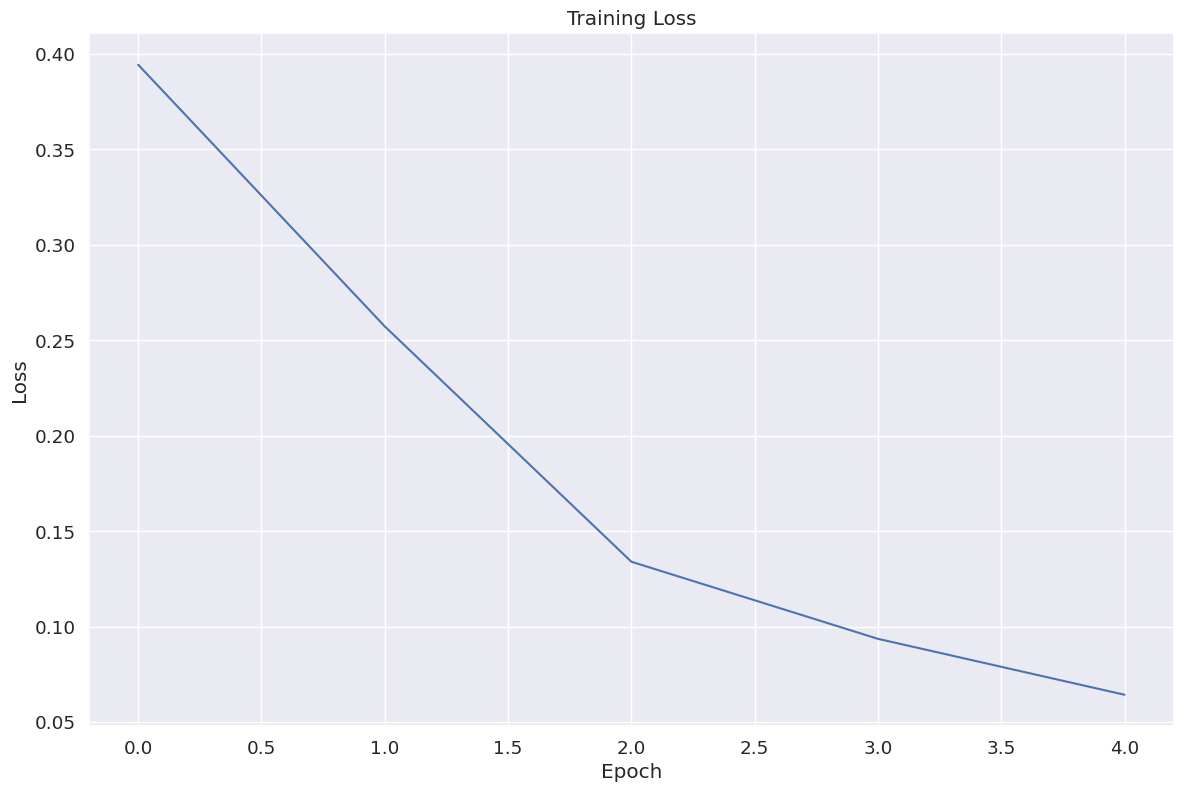

In [57]:
import matplotlib.pyplot as plt
# Plot the loss curve
plt.plot(loss_values)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [58]:
results = Dcnn.evaluate(test_dataset)
print(results)

166/166 [==============================] - 4s 19ms/step - loss: 0.5105 - accuracy: 0.8417 - precision: 0.8903 - recall: 0.8784
[0.5104794502258301, 0.8416792154312134, 0.890304684638977, 0.8783820867538452]


In [59]:
#Dcnn.fit(train_dataset,
        # epochs=NB_EPOCHS)

In [60]:
#results = Dcnn.evaluate(test_dataset)
#print(results)

In [61]:
def get_prediction(sentence):
    tokens = encode_sentence(sentence)
    inputs = tf.expand_dims(tokens, 0)

    output = Dcnn(inputs, training=False)

    sentiment = math.floor(output*2)

    if sentiment == 0:
        print("Output of the model: {}\nPredicted sentiment: negative.".format(
            output))
    elif sentiment == 1:
        print("Output of the model: {}\nPredicted sentiment: positive.".format(
            output))

In [62]:
get_prediction("This medicine was pretty amazing.")

Output of the model: [[0.9995415]]
Predicted sentiment: positive.


In [63]:
get_prediction("This medicine was worst has side effect")

Output of the model: [[0.00293801]]
Predicted sentiment: negative.


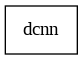

In [64]:
tf.keras.utils.plot_model(Dcnn)